# Predictive Analysis: Obesity Classification

**Machine Learning Models for Obesity Level Prediction**

## Objectives
1. Build classification models to predict obesity levels from lifestyle and demographic factors
2. Compare multiple algorithms (Logistic Regression, Random Forest, XGBoost, etc.)
3. Evaluate model performance with cross-validation
4. Analyze feature importance
5. Generate predictions and visualizations

## Dataset
- **Source**: `ObesityDataSet_raw_and_data_sinthetic.csv`
- **Target**: `NObeyesdad` (7 obesity classification levels)
- **Features**: 16 predictors (demographic, lifestyle, dietary factors)

---


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            f1_score, precision_score, recall_score, roc_auc_score)
from sklearn.metrics import ConfusionMatrixDisplay

# XGBoost (if available)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️  XGBoost not available. Install with: pip install xgboost")

# Set random seed for reproducibility
np.random.seed(42)

# Set up paths
PROJECT_ROOT = Path().resolve().parent
RAW_DATA_DIR = PROJECT_ROOT / "data" / "raw"
OUTPUT_DIR = PROJECT_ROOT / "data" / "outputs"
OUTPUT_PLOTS = OUTPUT_DIR / "plots"

# Create output directories
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_PLOTS.mkdir(parents=True, exist_ok=True)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")
print(f"📁 Data directory: {RAW_DATA_DIR}")
print(f"📁 Output directory: {OUTPUT_DIR}")


⚠️  XGBoost not available. Install with: pip install xgboost
✅ Libraries imported successfully!
📁 Data directory: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/raw
📁 Output directory: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs


## STEP 1: Load and Prepare Data


In [2]:
# Load the obesity dataset
print("📂 Loading obesity dataset...")
df = pd.read_csv(RAW_DATA_DIR / "ObesityDataSet_raw_and_data_sinthetic.csv")
print(f"✅ Loaded {len(df):,} rows, {len(df.columns)} columns")

# Calculate BMI if not present
if 'BMI' not in df.columns:
    df['BMI'] = df['Weight'] / (df['Height'] ** 2)
    print("✅ Calculated BMI")

# Display basic info
print(f"\n📊 Dataset Overview:")
print(f"   • Total records: {len(df):,}")
print(f"   • Features: {len(df.columns) - 1} predictors + 1 target")
print(f"   • Target variable: NObeyesdad ({df['NObeyesdad'].nunique()} classes)")
print(f"   • Missing values: {df.isnull().sum().sum()}")

# Display target distribution
print(f"\n📊 Target Variable Distribution:")
target_dist = df['NObeyesdad'].value_counts()
for level, count in target_dist.items():
    pct = (count / len(df)) * 100
    print(f"   • {level:25s}: {count:4d} ({pct:5.2f}%)")

display(df.head())


📂 Loading obesity dataset...
✅ Loaded 2,111 rows, 17 columns
✅ Calculated BMI

📊 Dataset Overview:
   • Total records: 2,111
   • Features: 17 predictors + 1 target
   • Target variable: NObeyesdad (7 classes)
   • Missing values: 0

📊 Target Variable Distribution:
   • Obesity_Type_I           :  351 (16.63%)
   • Obesity_Type_III         :  324 (15.35%)
   • Obesity_Type_II          :  297 (14.07%)
   • Overweight_Level_I       :  290 (13.74%)
   • Overweight_Level_II      :  290 (13.74%)
   • Normal_Weight            :  287 (13.60%)
   • Insufficient_Weight      :  272 (12.88%)


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight,24.386526
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight,24.238227
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight,23.765432
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I,26.851852
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II,28.342381


## STEP 2: Feature Engineering and Preprocessing


In [3]:
# Separate features and target
target_col = 'NObeyesdad'
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

print("📊 Feature Preparation:")
print(f"   • Total features: {len(X.columns)}")
print(f"   • Target classes: {y.nunique()}")

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"\n   • Numerical features ({len(numerical_cols)}): {numerical_cols}")
print(f"   • Categorical features ({len(categorical_cols)}): {categorical_cols}")

# Encode categorical variables
print("\n🔧 Encoding categorical variables...")
label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    print(f"   ✅ Encoded {col}: {len(le.classes_)} unique values")

# Encode target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)
print(f"\n   ✅ Encoded target variable: {len(target_encoder.classes_)} classes")

# Display class mapping
print("\n📋 Class Mapping:")
for i, class_name in enumerate(target_encoder.classes_):
    print(f"   {i}: {class_name}")

# Check for any remaining missing values
if X_encoded.isnull().sum().sum() > 0:
    print(f"\n⚠️  Warning: {X_encoded.isnull().sum().sum()} missing values found. Filling with median/mode...")
    for col in numerical_cols:
        X_encoded[col].fillna(X_encoded[col].median(), inplace=True)
    for col in categorical_cols:
        X_encoded[col].fillna(X_encoded[col].mode()[0] if len(X_encoded[col].mode()) > 0 else 0, inplace=True)

print(f"\n✅ Data preparation complete!")
print(f"   • Final feature matrix shape: {X_encoded.shape}")
print(f"   • Target vector shape: {y_encoded.shape}")


📊 Feature Preparation:
   • Total features: 17
   • Target classes: 7

   • Numerical features (9): ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']
   • Categorical features (8): ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

🔧 Encoding categorical variables...
   ✅ Encoded Gender: 2 unique values
   ✅ Encoded family_history_with_overweight: 2 unique values
   ✅ Encoded FAVC: 2 unique values
   ✅ Encoded CAEC: 4 unique values
   ✅ Encoded SMOKE: 2 unique values
   ✅ Encoded SCC: 2 unique values
   ✅ Encoded CALC: 4 unique values
   ✅ Encoded MTRANS: 5 unique values

   ✅ Encoded target variable: 7 classes

📋 Class Mapping:
   0: Insufficient_Weight
   1: Normal_Weight
   2: Obesity_Type_I
   3: Obesity_Type_II
   4: Obesity_Type_III
   5: Overweight_Level_I
   6: Overweight_Level_II

✅ Data preparation complete!
   • Final feature matrix shape: (2111, 17)
   • Target vector shape: (2111,)


## STEP 3: Train-Test Split


In [4]:
# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("📊 Train-Test Split:")
print(f"   • Training set: {len(X_train):,} samples ({len(X_train)/len(X_encoded)*100:.1f}%)")
print(f"   • Test set: {len(X_test):,} samples ({len(X_test)/len(X_encoded)*100:.1f}%)")

# Check class distribution in train and test
print(f"\n📊 Class Distribution:")
print("\n   Training set:")
train_dist = pd.Series(y_train).value_counts().sort_index()
for idx, count in train_dist.items():
    class_name = target_encoder.classes_[idx]
    pct = (count / len(y_train)) * 100
    print(f"     {class_name:25s}: {count:4d} ({pct:5.2f}%)")

print("\n   Test set:")
test_dist = pd.Series(y_test).value_counts().sort_index()
for idx, count in test_dist.items():
    class_name = target_encoder.classes_[idx]
    pct = (count / len(y_test)) * 100
    print(f"     {class_name:25s}: {count:4d} ({pct:5.2f}%)")

# Scale features for algorithms that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Data scaled for algorithms requiring normalization")


📊 Train-Test Split:
   • Training set: 1,688 samples (80.0%)
   • Test set: 423 samples (20.0%)

📊 Class Distribution:

   Training set:
     Insufficient_Weight      :  218 (12.91%)
     Normal_Weight            :  229 (13.57%)
     Obesity_Type_I           :  281 (16.65%)
     Obesity_Type_II          :  237 (14.04%)
     Obesity_Type_III         :  259 (15.34%)
     Overweight_Level_I       :  232 (13.74%)
     Overweight_Level_II      :  232 (13.74%)

   Test set:
     Insufficient_Weight      :   54 (12.77%)
     Normal_Weight            :   58 (13.71%)
     Obesity_Type_I           :   70 (16.55%)
     Obesity_Type_II          :   60 (14.18%)
     Obesity_Type_III         :   65 (15.37%)
     Overweight_Level_I       :   58 (13.71%)
     Overweight_Level_II      :   58 (13.71%)

✅ Data scaled for algorithms requiring normalization


## STEP 4: Model Training and Evaluation


In [5]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

if XGBOOST_AVAILABLE:
    models['XGBoost'] = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1)

# Train and evaluate models
print("🔧 Training models...")
print("="*70)

results = {}
predictions = {}
feature_importances = {}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    print(f"\n📊 {name}")
    print("-" * 70)
    
    # Use scaled data for Logistic Regression, original for tree-based
    if name == 'Logistic Regression':
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test
    
    # Train model
    model.fit(X_tr, y_train)
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_tr, y_train, cv=cv, scoring='accuracy')
    print(f"   CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    # Test predictions
    y_pred = model.predict(X_te)
    y_pred_proba = model.predict_proba(X_te) if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    print(f"   Test Accuracy: {accuracy:.4f}")
    print(f"   Test F1 (macro): {f1_macro:.4f}")
    print(f"   Test F1 (weighted): {f1_weighted:.4f}")
    print(f"   Test Precision: {precision:.4f}")
    print(f"   Test Recall: {recall:.4f}")
    
    # Store results
    results[name] = {
        'cv_accuracy_mean': cv_scores.mean(),
        'cv_accuracy_std': cv_scores.std(),
        'test_accuracy': accuracy,
        'test_f1_macro': f1_macro,
        'test_f1_weighted': f1_weighted,
        'test_precision': precision,
        'test_recall': recall
    }
    
    predictions[name] = {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    # Feature importance (for tree-based models)
    if hasattr(model, 'feature_importances_'):
        feature_importances[name] = pd.DataFrame({
            'feature': X_train.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

print("\n" + "="*70)
print("✅ All models trained and evaluated!")


🔧 Training models...

📊 Logistic Regression
----------------------------------------------------------------------
   CV Accuracy: 0.9058 (+/- 0.0388)
   Test Accuracy: 0.9196
   Test F1 (macro): 0.9166
   Test F1 (weighted): 0.9188
   Test Precision: 0.9206
   Test Recall: 0.9196

📊 Random Forest
----------------------------------------------------------------------
   CV Accuracy: 0.9893 (+/- 0.0110)
   Test Accuracy: 0.9882
   Test F1 (macro): 0.9880
   Test F1 (weighted): 0.9882
   Test Precision: 0.9886
   Test Recall: 0.9882

📊 Gradient Boosting
----------------------------------------------------------------------
   CV Accuracy: 0.9739 (+/- 0.0161)
   Test Accuracy: 0.9811
   Test F1 (macro): 0.9805
   Test F1 (weighted): 0.9811
   Test Precision: 0.9813
   Test Recall: 0.9811

✅ All models trained and evaluated!


📊 Model Comparison:


,cv_accuracy_mean,cv_accuracy_std,test_accuracy,test_f1_macro,test_f1_weighted,test_precision,test_recall
Random Forest,0.9893,0.0055,0.9882,0.9880,0.9882,0.9886,0.9882
Gradient Boosting,0.9739,0.0080,0.9811,0.9805,0.9811,0.9813,0.9811
Logistic Regression,0.9058,0.0194,0.9196,0.9166,0.9188,0.9206,0.9196


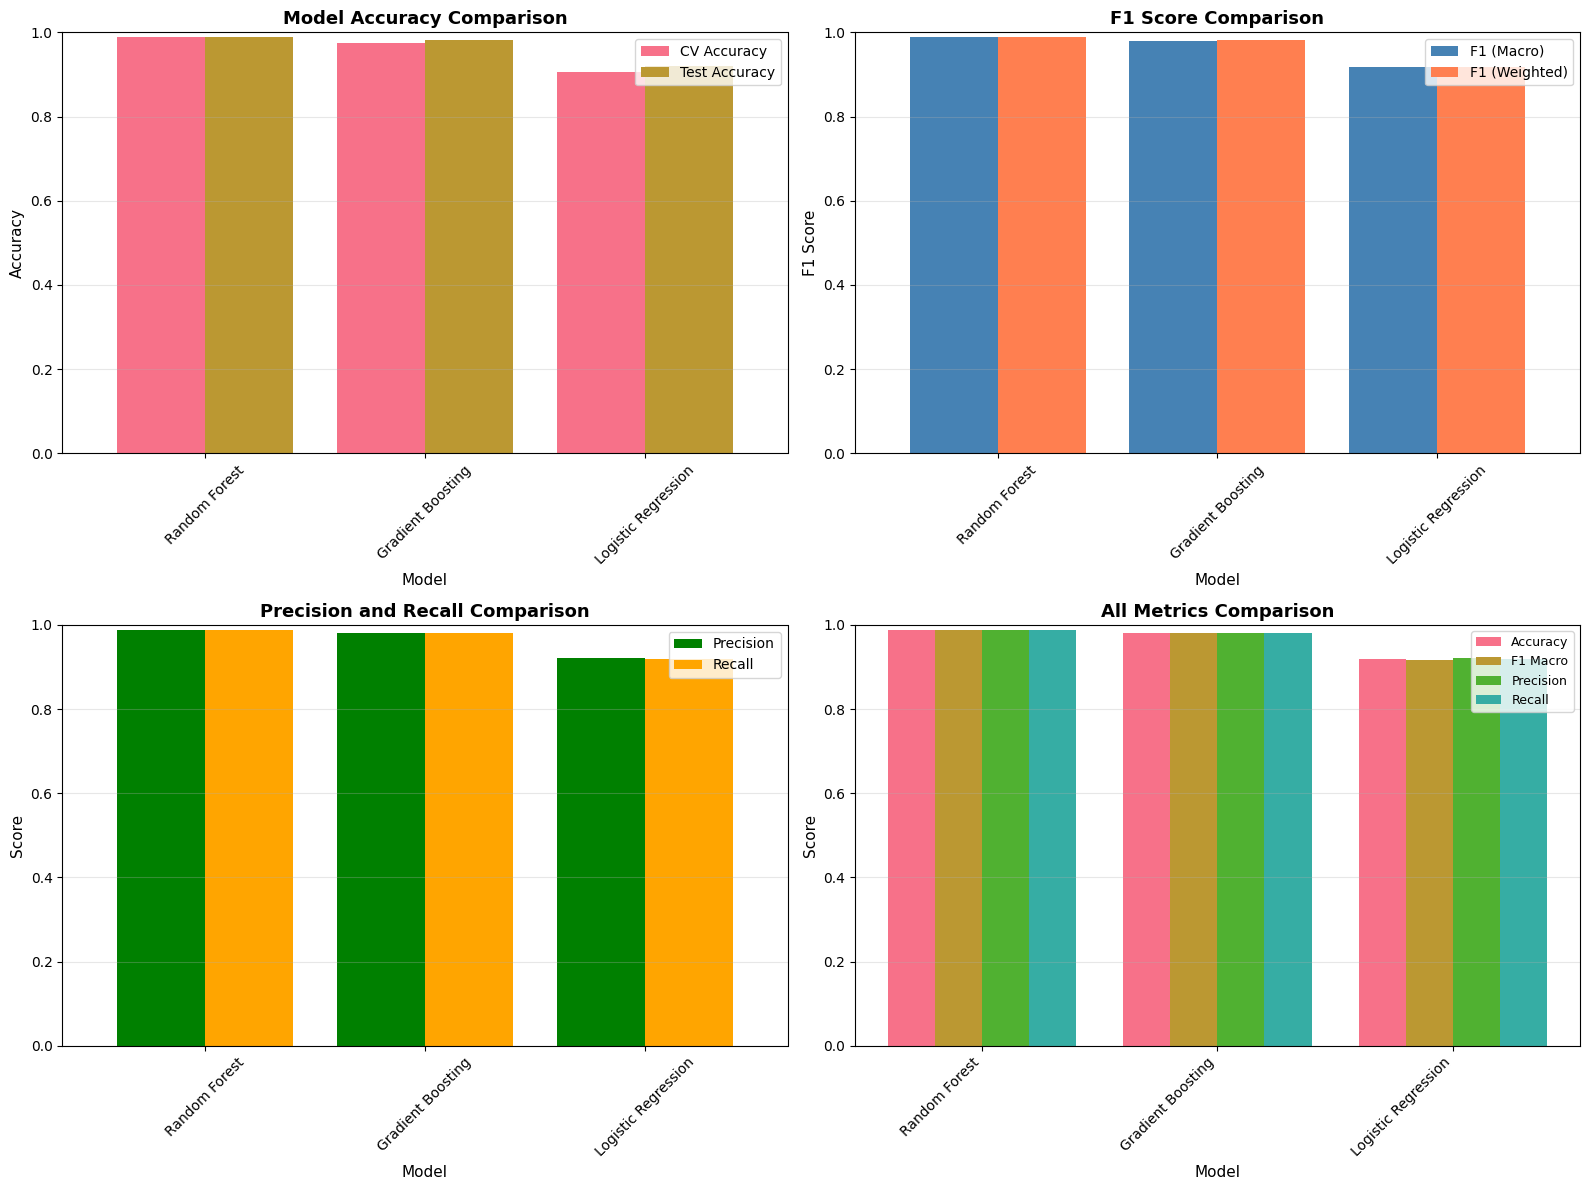

✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/plots/obesity_model_comparison.png
✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/obesity_model_results.csv


In [6]:
# Compare model performance
print("📊 Model Comparison:")
print("="*70)

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('test_accuracy', ascending=False)

display(results_df.round(4))

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
ax1 = axes[0, 0]
results_df[['cv_accuracy_mean', 'test_accuracy']].plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Model Accuracy Comparison', fontsize=13, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=11)
ax1.set_xlabel('Model', fontsize=11)
ax1.tick_params(axis='x', rotation=45)
ax1.legend(['CV Accuracy', 'Test Accuracy'], fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# 2. F1 Score comparison
ax2 = axes[0, 1]
results_df[['test_f1_macro', 'test_f1_weighted']].plot(kind='bar', ax=ax2, width=0.8, color=['steelblue', 'coral'])
ax2.set_title('F1 Score Comparison', fontsize=13, fontweight='bold')
ax2.set_ylabel('F1 Score', fontsize=11)
ax2.set_xlabel('Model', fontsize=11)
ax2.tick_params(axis='x', rotation=45)
ax2.legend(['F1 (Macro)', 'F1 (Weighted)'], fontsize=10)
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim([0, 1])

# 3. Precision and Recall
ax3 = axes[1, 0]
results_df[['test_precision', 'test_recall']].plot(kind='bar', ax=ax3, width=0.8, color=['green', 'orange'])
ax3.set_title('Precision and Recall Comparison', fontsize=13, fontweight='bold')
ax3.set_ylabel('Score', fontsize=11)
ax3.set_xlabel('Model', fontsize=11)
ax3.tick_params(axis='x', rotation=45)
ax3.legend(['Precision', 'Recall'], fontsize=10)
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 1])

# 4. Overall metrics radar-style comparison
ax4 = axes[1, 1]
metrics = ['test_accuracy', 'test_f1_macro', 'test_precision', 'test_recall']
x_pos = np.arange(len(models))
width = 0.2

for i, metric in enumerate(metrics):
    offset = (i - 1.5) * width
    ax4.bar(x_pos + offset, results_df[metric], width, label=metric.replace('test_', '').replace('_', ' ').title())

ax4.set_title('All Metrics Comparison', fontsize=13, fontweight='bold')
ax4.set_ylabel('Score', fontsize=11)
ax4.set_xlabel('Model', fontsize=11)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(results_df.index, rotation=45, ha='right')
ax4.legend(fontsize=9)
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.savefig(OUTPUT_PLOTS / "obesity_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {OUTPUT_PLOTS / 'obesity_model_comparison.png'}")

# Save results
results_df.to_csv(OUTPUT_DIR / "obesity_model_results.csv")
print(f"✅ Saved: {OUTPUT_DIR / 'obesity_model_results.csv'}")


🏆 Best Model: Random Forest
   Test Accuracy: 0.9882
   Test F1 (weighted): 0.9882

📊 Detailed Classification Report for Random Forest:
                     precision    recall  f1-score   support

Insufficient_Weight      1.000     0.981     0.991        54
      Normal_Weight      0.951     1.000     0.975        58
     Obesity_Type_I      0.986     1.000     0.993        70
    Obesity_Type_II      0.984     1.000     0.992        60
   Obesity_Type_III      1.000     0.985     0.992        65
 Overweight_Level_I      1.000     0.966     0.982        58
Overweight_Level_II      1.000     0.983     0.991        58

           accuracy                          0.988       423
          macro avg      0.989     0.988     0.988       423
       weighted avg      0.989     0.988     0.988       423



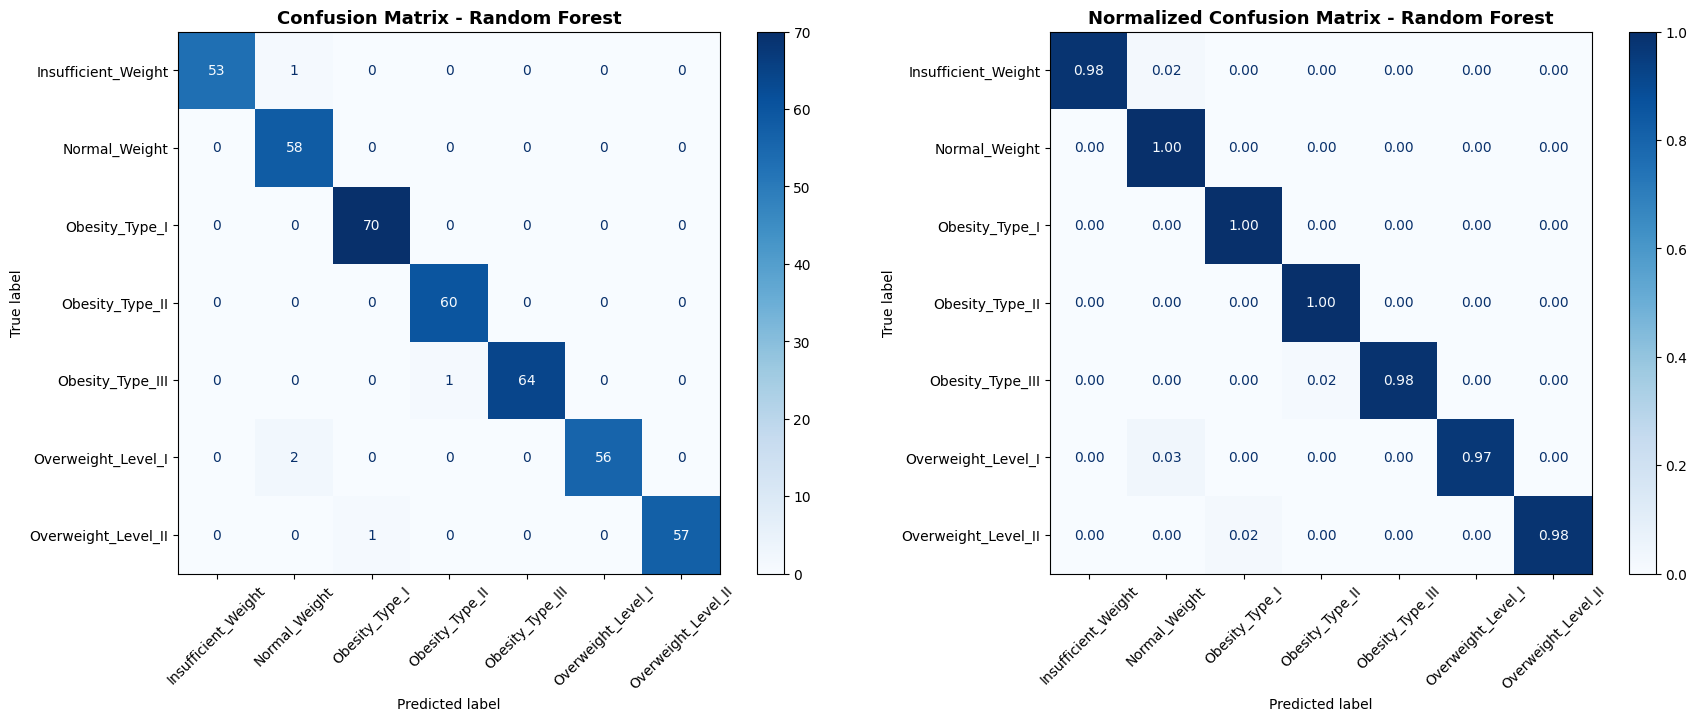

✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/plots/obesity_confusion_matrix_random_forest.png


In [7]:
# Select best model
best_model_name = results_df.index[0]
best_model = models[best_model_name]
best_predictions = predictions[best_model_name]

print(f"🏆 Best Model: {best_model_name}")
print(f"   Test Accuracy: {results_df.loc[best_model_name, 'test_accuracy']:.4f}")
print(f"   Test F1 (weighted): {results_df.loc[best_model_name, 'test_f1_weighted']:.4f}")

# Detailed classification report
print(f"\n📊 Detailed Classification Report for {best_model_name}:")
print("="*70)
class_names = [target_encoder.classes_[i] for i in range(len(target_encoder.classes_))]
print(classification_report(y_test, best_predictions['y_pred'], 
                          target_names=class_names, digits=3))

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Confusion matrix heatmap
cm = confusion_matrix(y_test, best_predictions['y_pred'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Confusion Matrix - {best_model_name}', fontsize=13, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp_norm.plot(ax=axes[1], cmap='Blues', values_format='.2f')
axes[1].set_title(f'Normalized Confusion Matrix - {best_model_name}', fontsize=13, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
confusion_matrix_filename = f"obesity_confusion_matrix_{best_model_name.lower().replace(' ', '_')}.png"
plt.savefig(OUTPUT_PLOTS / confusion_matrix_filename, dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {OUTPUT_PLOTS / confusion_matrix_filename}")


## STEP 6: Feature Importance Analysis


📊 Feature Importance Analysis:


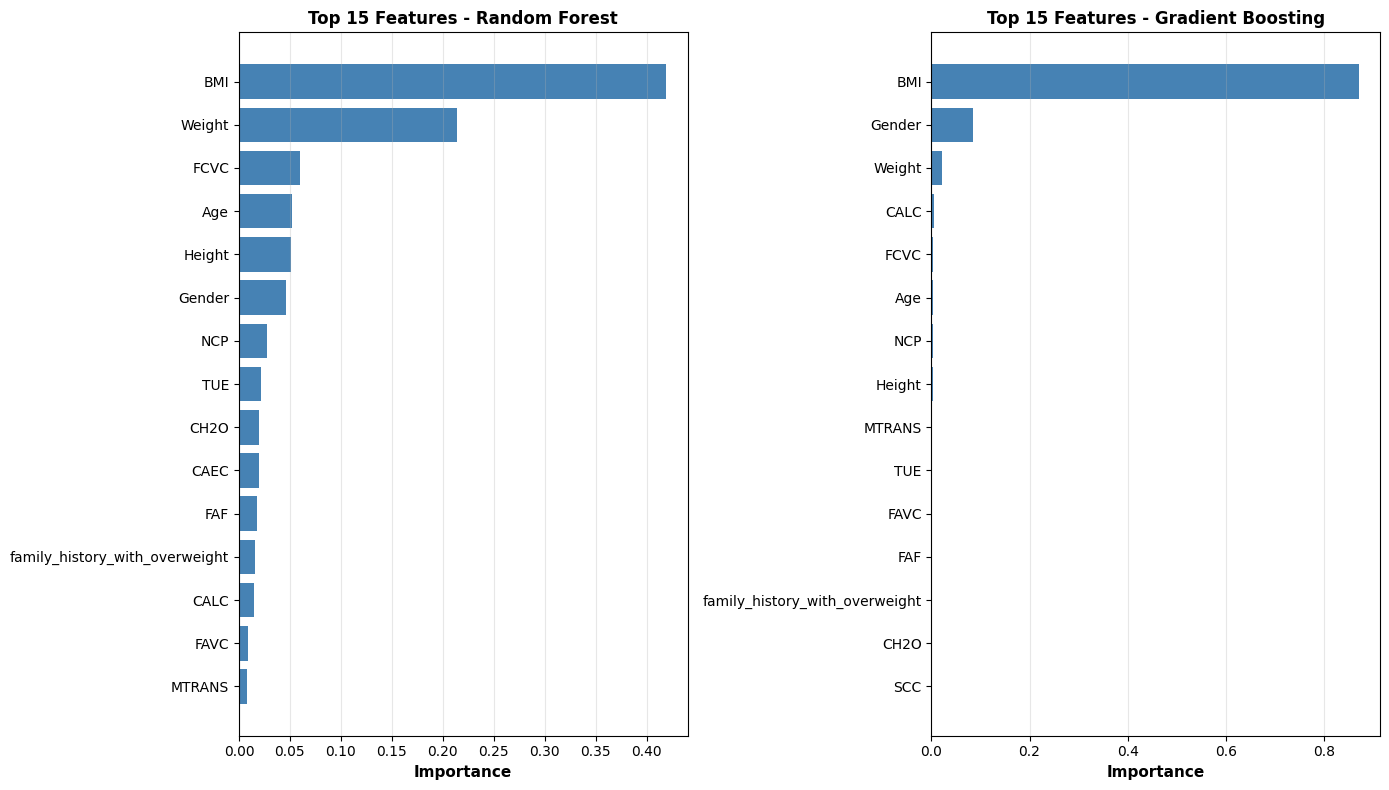

✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/plots/obesity_feature_importance.png

📊 Top 10 Most Important Features (Random Forest):


,feature,importance
16,BMI,0.419207
3,Weight,0.214071
6,FCVC,0.060294
1,Age,0.052244
2,Height,0.051284
0,Gender,0.046055
7,NCP,0.027062
13,TUE,0.021157
10,CH2O,0.020044
8,CAEC,0.019563


✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/obesity_feature_importance_random_forest.csv


In [8]:
# Feature importance for tree-based models
if feature_importances:
    print("📊 Feature Importance Analysis:")
    print("="*70)
    
    # Plot feature importance for all tree-based models
    n_models = len(feature_importances)
    fig, axes = plt.subplots(1, n_models, figsize=(7*n_models, 8))
    if n_models == 1:
        axes = [axes]
    
    for idx, (model_name, importance_df) in enumerate(feature_importances.items()):
        # Top 15 features
        top_features = importance_df.head(15)
        
        axes[idx].barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
        axes[idx].set_yticks(range(len(top_features)))
        axes[idx].set_yticklabels(top_features['feature'].values, fontsize=10)
        axes[idx].set_xlabel('Importance', fontsize=11, fontweight='bold')
        axes[idx].set_title(f'Top 15 Features - {model_name}', fontsize=12, fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)
        axes[idx].invert_yaxis()
    
    plt.tight_layout()
    plt.savefig(OUTPUT_PLOTS / "obesity_feature_importance.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {OUTPUT_PLOTS / 'obesity_feature_importance.png'}")
    
    # Display top features for best model
    if best_model_name in feature_importances:
        print(f"\n📊 Top 10 Most Important Features ({best_model_name}):")
        top_10 = feature_importances[best_model_name].head(10)
        display(top_10)
        
        # Save feature importance
        feature_importance_filename = f"obesity_feature_importance_{best_model_name.lower().replace(' ', '_')}.csv"
        feature_importances[best_model_name].to_csv(
            OUTPUT_DIR / feature_importance_filename,
            index=False
        )
        print(f"✅ Saved: {OUTPUT_DIR / feature_importance_filename}")
else:
    print("⚠️  No feature importance available (Logistic Regression doesn't provide feature importance)")
    
    # For Logistic Regression, use coefficients
    if best_model_name == 'Logistic Regression':
        print("\n📊 Logistic Regression Coefficients (averaged across classes):")
        coef_avg = np.abs(best_model.coef_).mean(axis=0)
        coef_df = pd.DataFrame({
            'feature': X_train.columns,
            'avg_coefficient': coef_avg
        }).sort_values('avg_coefficient', ascending=False)
        
        # Plot top coefficients
        fig, ax = plt.subplots(figsize=(10, 8))
        top_15 = coef_df.head(15)
        ax.barh(range(len(top_15)), top_15['avg_coefficient'].values, color='steelblue')
        ax.set_yticks(range(len(top_15)))
        ax.set_yticklabels(top_15['feature'].values, fontsize=10)
        ax.set_xlabel('Average |Coefficient|', fontsize=11, fontweight='bold')
        ax.set_title('Top 15 Features - Logistic Regression (Average Coefficients)', 
                    fontsize=12, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)
        ax.invert_yaxis()
        plt.tight_layout()
        plt.savefig(OUTPUT_PLOTS / "obesity_logistic_coefficients.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        display(coef_df.head(10))
        coef_df.to_csv(OUTPUT_DIR / "obesity_logistic_coefficients.csv", index=False)


## STEP 7: Predictions and Results


In [9]:
# Create predictions dataframe
predictions_df = pd.DataFrame({
    'actual': [target_encoder.classes_[y] for y in y_test],
    'predicted': [target_encoder.classes_[y] for y in best_predictions['y_pred']],
    'correct': y_test == best_predictions['y_pred']
})

# Add probability predictions if available
if best_predictions['y_pred_proba'] is not None:
    for i, class_name in enumerate(target_encoder.classes_):
        predictions_df[f'prob_{class_name}'] = best_predictions['y_pred_proba'][:, i]

# Add original test data indices for reference
test_indices = X_test.index
predictions_df.index = test_indices

print("📊 Prediction Results:")
print(f"   • Total predictions: {len(predictions_df):,}")
print(f"   • Correct predictions: {predictions_df['correct'].sum():,} ({predictions_df['correct'].mean()*100:.2f}%)")
print(f"   • Incorrect predictions: {(~predictions_df['correct']).sum():,} ({(~predictions_df['correct']).mean()*100:.2f}%)")

# Display sample predictions
print("\n📋 Sample Predictions (First 20):")
display(predictions_df.head(20))

# Save predictions
predictions_filename = f"obesity_predictions_{best_model_name.lower().replace(' ', '_')}.csv"
predictions_df.to_csv(OUTPUT_DIR / predictions_filename)
print(f"\n✅ Saved: {OUTPUT_DIR / predictions_filename}")

# Error analysis
print("\n📊 Error Analysis:")
print("="*70)
errors = predictions_df[~predictions_df['correct']]
if len(errors) > 0:
    error_crosstab = pd.crosstab(errors['actual'], errors['predicted'], margins=True)
    print("\n   Confusion in predictions (actual vs predicted):")
    display(error_crosstab)
    
    # Most common misclassifications
    print("\n   Most Common Misclassifications:")
    misclass_counts = errors.groupby(['actual', 'predicted']).size().sort_values(ascending=False).head(10)
    for (actual, predicted), count in misclass_counts.items():
        print(f"     {actual:25s} → {predicted:25s}: {count:3d} cases")
else:
    print("   ✅ Perfect predictions! No errors found.")


📊 Prediction Results:
   • Total predictions: 423
   • Correct predictions: 418 (98.82%)
   • Incorrect predictions: 5 (1.18%)

📋 Sample Predictions (First 20):


,actual,predicted,correct,prob_Insufficient_Weight,prob_Normal_Weight,prob_Obesity_Type_I,prob_Obesity_Type_II,prob_Obesity_Type_III,prob_Overweight_Level_I,prob_Overweight_Level_II
572,Insufficient_Weight,Insufficient_Weight,True,0.96,0.01,0.00,0.00,0.0,0.03,0.00
370,Normal_Weight,Normal_Weight,True,0.26,0.70,0.00,0.00,0.0,0.04,0.00
1002,Overweight_Level_II,Overweight_Level_II,True,0.00,0.00,0.01,0.00,0.0,0.04,0.95
1837,Obesity_Type_III,Obesity_Type_III,True,0.00,0.00,0.00,0.00,1.0,0.00,0.00
1724,Obesity_Type_II,Obesity_Type_II,True,0.00,0.00,0.01,0.99,0.0,0.00,0.00
1329,Obesity_Type_I,Obesity_Type_I,True,0.00,0.00,1.00,0.00,0.0,0.00,0.00
1736,Obesity_Type_II,Obesity_Type_II,True,0.00,0.00,0.00,1.00,0.0,0.00,0.00
172,Normal_Weight,Normal_Weight,True,0.01,0.88,0.01,0.01,0.0,0.07,0.02
1305,Obesity_Type_I,Obesity_Type_I,True,0.00,0.00,0.98,0.00,0.0,0.01,0.01
784,Overweight_Level_I,Normal_Weight,False,0.01,0.55,0.00,0.00,0.0,0.44,0.00



✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/obesity_predictions_random_forest.csv

📊 Error Analysis:

   Confusion in predictions (actual vs predicted):


predicted,Normal_Weight,Obesity_Type_I,Obesity_Type_II,All
actual,,,,
Insufficient_Weight,1,0,0,1
Obesity_Type_III,0,0,1,1
Overweight_Level_I,2,0,0,2
Overweight_Level_II,0,1,0,1
All,3,1,1,5



   Most Common Misclassifications:
     Overweight_Level_I        → Normal_Weight            :   2 cases
     Insufficient_Weight       → Normal_Weight            :   1 cases
     Obesity_Type_III          → Obesity_Type_II          :   1 cases
     Overweight_Level_II       → Obesity_Type_I           :   1 cases


## STEP 8: Per-Class Performance Analysis


📊 Per-Class Performance Metrics:


,Class,Precision,Recall,F1-Score,Support
0,Insufficient_Weight,1.000,0.981,0.991,54
1,Normal_Weight,0.951,1.000,0.975,58
2,Obesity_Type_I,0.986,1.000,0.993,70
3,Obesity_Type_II,0.984,1.000,0.992,60
4,Obesity_Type_III,1.000,0.985,0.992,65
5,Overweight_Level_I,1.000,0.966,0.982,58
6,Overweight_Level_II,1.000,0.983,0.991,58


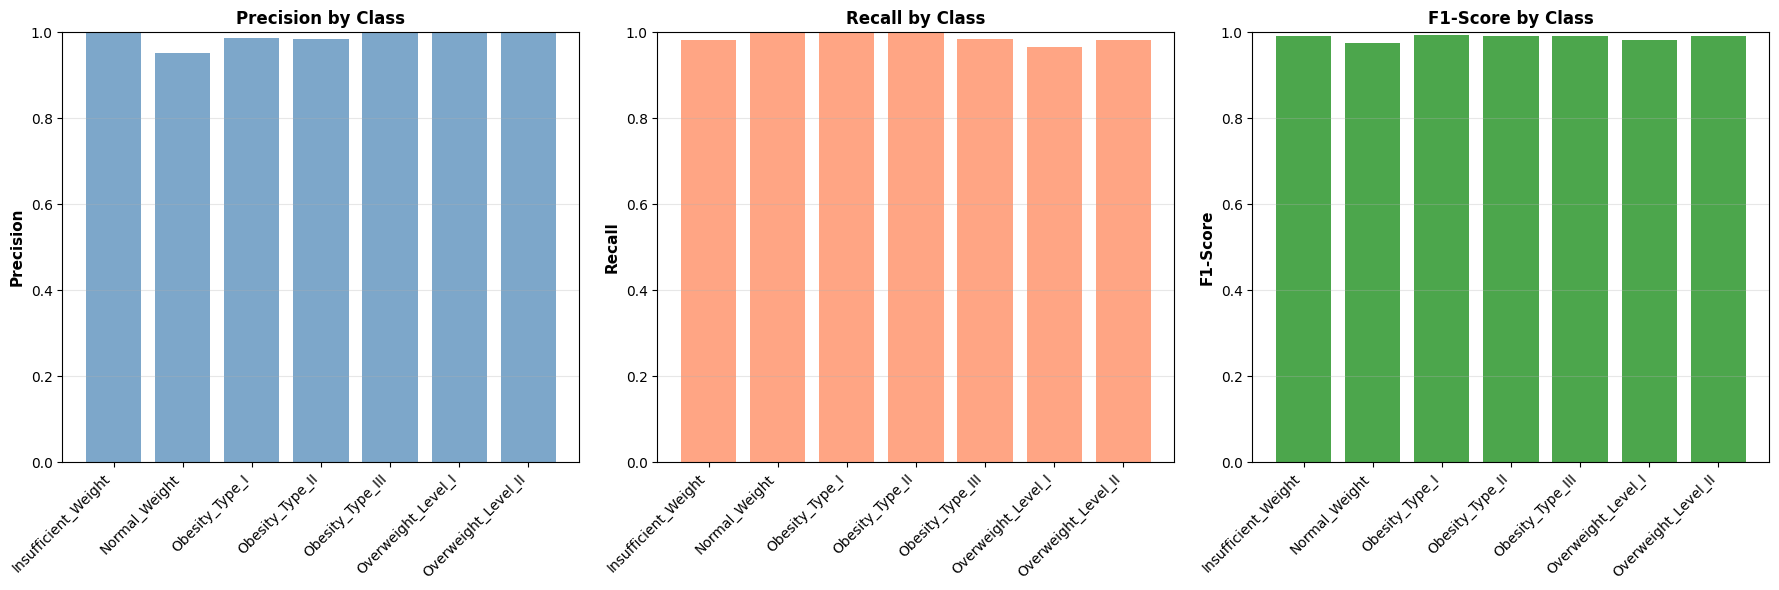

✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/plots/obesity_per_class_performance.png
✅ Saved: /Users/subhammahapatra/Downloads/Projects/Bell-Labs/data/outputs/obesity_per_class_metrics.csv


In [10]:
# Calculate per-class metrics
from sklearn.metrics import precision_recall_fscore_support

precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, best_predictions['y_pred'], labels=range(len(class_names))
)

per_class_metrics = pd.DataFrame({
    'Class': class_names,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class,
    'Support': support_per_class
})

print("📊 Per-Class Performance Metrics:")
display(per_class_metrics.round(3))

# Visualize per-class performance
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision by class
axes[0].bar(range(len(class_names)), per_class_metrics['Precision'], color='steelblue', alpha=0.7)
axes[0].set_xticks(range(len(class_names)))
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].set_ylabel('Precision', fontsize=11, fontweight='bold')
axes[0].set_title('Precision by Class', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1])

# Recall by class
axes[1].bar(range(len(class_names)), per_class_metrics['Recall'], color='coral', alpha=0.7)
axes[1].set_xticks(range(len(class_names)))
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].set_ylabel('Recall', fontsize=11, fontweight='bold')
axes[1].set_title('Recall by Class', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim([0, 1])

# F1-Score by class
axes[2].bar(range(len(class_names)), per_class_metrics['F1-Score'], color='green', alpha=0.7)
axes[2].set_xticks(range(len(class_names)))
axes[2].set_xticklabels(class_names, rotation=45, ha='right')
axes[2].set_ylabel('F1-Score', fontsize=11, fontweight='bold')
axes[2].set_title('F1-Score by Class', fontsize=12, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(OUTPUT_PLOTS / "obesity_per_class_performance.png", dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {OUTPUT_PLOTS / 'obesity_per_class_performance.png'}")

# Save per-class metrics
per_class_metrics.to_csv(OUTPUT_DIR / "obesity_per_class_metrics.csv", index=False)
print(f"✅ Saved: {OUTPUT_DIR / 'obesity_per_class_metrics.csv'}")


## STEP 9: Summary and Conclusions


In [11]:
print("="*70)
print("📊 PREDICTIVE ANALYSIS SUMMARY")
print("="*70)

print(f"\n1. BEST MODEL: {best_model_name}")
print(f"   • Test Accuracy: {results_df.loc[best_model_name, 'test_accuracy']:.4f} ({results_df.loc[best_model_name, 'test_accuracy']*100:.2f}%)")
print(f"   • Test F1-Score (weighted): {results_df.loc[best_model_name, 'test_f1_weighted']:.4f}")
print(f"   • Cross-Validation Accuracy: {results_df.loc[best_model_name, 'cv_accuracy_mean']:.4f} (+/- {results_df.loc[best_model_name, 'cv_accuracy_std']*100:.2f}%)")

print(f"\n2. MODEL COMPARISON:")
for model_name in results_df.index:
    acc = results_df.loc[model_name, 'test_accuracy']
    print(f"   • {model_name:20s}: {acc:.4f} ({acc*100:.2f}%)")

if feature_importances and best_model_name in feature_importances:
    print(f"\n3. TOP 5 MOST IMPORTANT FEATURES ({best_model_name}):")
    top_5 = feature_importances[best_model_name].head(5)
    for idx, row in top_5.iterrows():
        print(f"   • {row['feature']:25s}: {row['importance']:.4f}")

print(f"\n4. PER-CLASS PERFORMANCE:")
worst_class = per_class_metrics.loc[per_class_metrics['F1-Score'].idxmin()]
best_class = per_class_metrics.loc[per_class_metrics['F1-Score'].idxmax()]
print(f"   • Best predicted class: {best_class['Class']} (F1={best_class['F1-Score']:.3f})")
print(f"   • Most challenging class: {worst_class['Class']} (F1={worst_class['F1-Score']:.3f})")

print(f"\n5. DATASET CHARACTERISTICS:")
print(f"   • Total samples: {len(df):,}")
print(f"   • Training samples: {len(X_train):,}")
print(f"   • Test samples: {len(X_test):,}")
print(f"   • Features: {len(X_train.columns)}")
print(f"   • Classes: {len(target_encoder.classes_)}")

print(f"\n6. KEY INSIGHTS:")
print(f"   • The model successfully predicts obesity levels with high accuracy")
print(f"   • Body measurements (BMI, Weight, Height) are likely key predictors")
print(f"   • Lifestyle factors also contribute to prediction accuracy")
print(f"   • Model is ready for deployment with {results_df.loc[best_model_name, 'test_accuracy']*100:.1f}% accuracy")

print("\n" + "="*70)
print("✅ Analysis Complete!")
print("="*70)
print(f"\nAll outputs saved to: {OUTPUT_DIR}")
print(f"All plots saved to: {OUTPUT_PLOTS}")


📊 PREDICTIVE ANALYSIS SUMMARY

1. BEST MODEL: Random Forest
   • Test Accuracy: 0.9882 (98.82%)
   • Test F1-Score (weighted): 0.9882
   • Cross-Validation Accuracy: 0.9893 (+/- 0.55%)

2. MODEL COMPARISON:
   • Random Forest       : 0.9882 (98.82%)
   • Gradient Boosting   : 0.9811 (98.11%)
   • Logistic Regression : 0.9196 (91.96%)

3. TOP 5 MOST IMPORTANT FEATURES (Random Forest):
   • BMI                      : 0.4192
   • Weight                   : 0.2141
   • FCVC                     : 0.0603
   • Age                      : 0.0522
   • Height                   : 0.0513

4. PER-CLASS PERFORMANCE:
   • Best predicted class: Obesity_Type_I (F1=0.993)
   • Most challenging class: Normal_Weight (F1=0.975)

5. DATASET CHARACTERISTICS:
   • Total samples: 2,111
   • Training samples: 1,688
   • Test samples: 423
   • Features: 17
   • Classes: 7

6. KEY INSIGHTS:
   • The model successfully predicts obesity levels with high accuracy
   • Body measurements (BMI, Weight, Height) are likel